## Cell-Aaverage Constant False Alarm Rate for pixel-wise ship detection

CA-CFAR model from the article: [Object Detection with Automotive Radar Sensors using CFAR Algorithms](https://www.jku.at/fileadmin/gruppen/183/Docs/Finished_Theses/Bachelor_Thesis_Katzlberger_final.pdf)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://ieeexplore.ieee.org/document/7729017/algorithms?tabFilter=dataset#algorithms)


In [1]:
import os
from os.path import join
import numpy as np 
import pandas as pd 
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor
from cfar import CA_CFAR

In [2]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

### Data Pre-processing
###### As we carry a pixel-wise classification, we will pick up only the dataset containing ships `(ship_positives)`.

Dataset presents 1596 ship containing SAR image chips from `Sentinel-1` (Extra Wide Swath) and `RADARSAT-2` sensors. 

In [4]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)
true_negative = pd.read_json(join(data_path, 'true_negatives.json'))

true_positives:  (1, 1596)


In [5]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

In [6]:
# check the polarisation mode of the dataset
plol = [ship_positives[i][0]['polarisation'] for i in range(ship_positives.size)]
pd.Series(Counter(plol))

HH    231
HV    149
VV    559
VH    657
dtype: int64

In [7]:
# print SAR imahe chip size
np.array(ship_positives[0][0]['patchgt']).shape

(101, 101)

In [14]:
# dsize = (101, 101)

# get true positive data
ship_positive_data = data_extractor(ship_positives, 'patchfu') # patchfu-101 |windowfu -21
# get the pixel based classes 
ship_positive_target = data_extractor(ship_positives, 'patchgt') # patchgt -101 |windowgt -21

In [15]:
# Resize the images
# dsize = (80, 80)
# ship_positive_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST) for image in ship_positive_data])
# target_80 = np.array([im_resize(image, dsize, interpolation=cv2.INTER_NEAREST ) for image in ship_positive_target])

In [16]:
# renam the variables for the sake of ease
data = ship_positive_data
target = ship_positive_target

In [17]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 101, 101)
Target shape:	 (1596, 101, 101)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

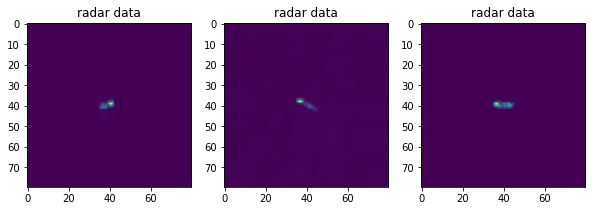

In [32]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(data[43,:,:])
axarr[2].set_title('radar data')

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

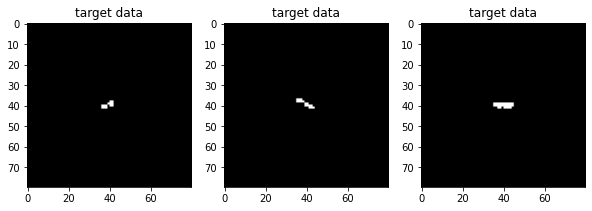

In [13]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(target[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(target[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(target[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Run CA-CFAR analysis

In [18]:
chip_data = ['windowfu', 'patchfu']
chip_target = ['windowgt', 'patchgt']
chip_size = [21, 101]
labels = ['0-not ship', '1-ship']

In [19]:
# Define parameters for CFAR
params = [10, 10, 1, 1]
P_fa = [9e-4, 10e-4, 11e-4]

# detedt_cfar = np.array([CA_CFAR(image, params, P_fa) for image in data])

In [22]:
results = {}
for p_fa in P_fa:
    print(f'P_fa: {p_fa}')
    for i in zip(chip_data, chip_target, chip_size):
        data = data_extractor(ship_positives, i[0])
        target = data_extractor(ship_positives, i[1])
        # apply Lee filter
#         data = np.array([lee_filter(image, 4) for image in data])

        detedt_cfar = np.array([CA_CFAR(image, params, p_fa) for image in data])
        report = classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels, output_dict=False)
    #     results[f'cfar_analysis_report_{i[2]}'] = report
        print(f'Image size: {i[2]} \n', report)

        if i[1] == 'patchgt':
            # Crop images from center with 80x80 size
            row, col = data[0].shape
            if row < 80 or col <80:
                raise ValueError('image size is not sufficient for cropping into 80x80 subimage')
                
            crow, ccol = int((row+1)//2) , int((col+1)//2)
            data = np.array([image[crow-40 : crow+40, ccol-40 : ccol+40] for image in ship_positive_data])
            target = np.array([image[crow-40 : crow+40, ccol-40 : ccol+40] for image in ship_positive_target])
            # apply Lee filter
#             data = np.array([lee_filter(image, 4) for image in data])
            
            detedt_cfar = np.array([CA_CFAR(image, params, p_fa) for image in data])
            report = classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels, output_dict=False)
    #         results[f'cfar_analysis_report_{other_im_sizes[0]}'] = report
            print(f'Image size: {data[0].shape[0]} \n', report)
    print('#-------------------------------------------------------------------')

P_fa: 0.0009
Image size: 21 
               precision    recall  f1-score   support

  0-not ship       0.99      1.00      0.99    678940
      1-ship       0.86      0.79      0.82     24896

    accuracy                           0.99    703836
   macro avg       0.92      0.89      0.91    703836
weighted avg       0.99      0.99      0.99    703836

Image size: 101 
               precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  16255900
      1-ship       0.26      0.82      0.40     24896

    accuracy                           1.00  16280796
   macro avg       0.63      0.91      0.70  16280796
weighted avg       1.00      1.00      1.00  16280796

Image size: 80 
               precision    recall  f1-score   support

  0-not ship       1.00      1.00      1.00  10189504
      1-ship       0.40      0.82      0.54     24896

    accuracy                           1.00  10214400
   macro avg       0.70      0.91      0.77  10214400
weighted 

#Classification report -101
labels = ['0-not ship', '1-ship']

print(classification_report(target.flatten(), detedt_cfar.flatten(), target_names=labels))
print('Confusion matrix \n', confusion_matrix(target.flatten(), detedt_cfar.flatten()))

In [64]:
(unique, counts) = np.unique(target, return_counts=True)
# class size
pd.Series(dict((unique, counts)))

0             1
678940    24896
dtype: int64

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

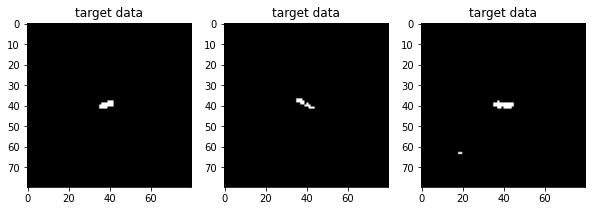

In [22]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(detedt_cfar[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(detedt_cfar[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(detedt_cfar[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images. Also one should ensure that inputs are 2d_arrays. If we pass also predicted data values of an image, the function returns bbox around the data values while vizualizing also the prediction labels on another image. However, it will still calculate the bbox parameters from label image.

<Figure size 432x288 with 0 Axes>

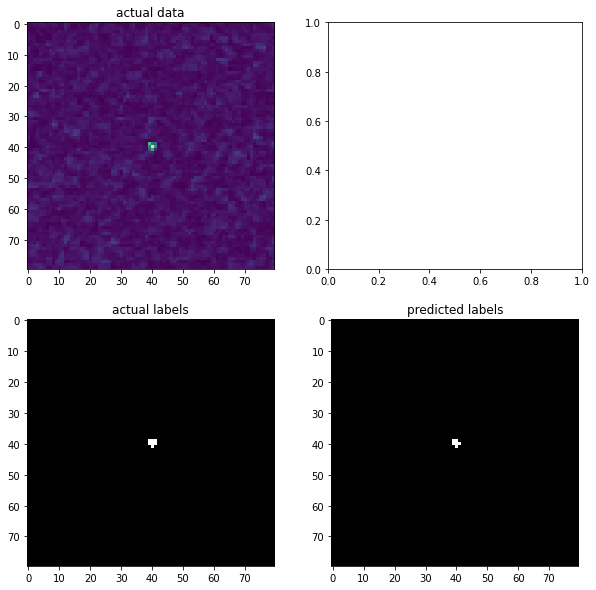

In [23]:
# define functions for vizualization 
def multiple_im_plot(no_image):
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(data[no_image])
    axarr[0,0].set_title('actual data')
    axarr[1,0].imshow(target[no_image], cmap="gray")
    axarr[1,0].set_title('actual labels')
    axarr[1,1].imshow(detedt_cfar[no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(67)   

<Figure size 432x288 with 0 Axes>

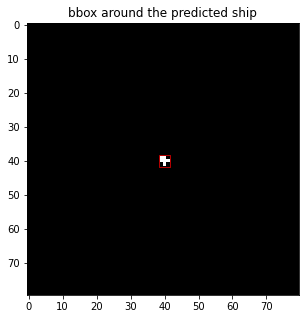

In [24]:
# vizualiza predicted ships with bbox
bbox_draw(detedt_cfar[67])